# 1.3.0 Measuring Segregation

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import geopandas as gpd

import statsmodels

import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append("../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Analyzing US Census Data in Python'
data = make_dir_line(modality, project)

raw = data('raw')

## 1.3.2 Calculating D for One State

In [5]:
tracts = pd.read_csv(raw /"tracts.csv", sep=',')
tracts['state'] = tracts['state'].astype(str)
tracts['county'] = tracts['county'].astype(str)
print(tracts.info())
tracts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74002 entries, 0 to 74001
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   74002 non-null  object
 1   county  74002 non-null  object
 2   tract   74002 non-null  int64 
 3   white   74002 non-null  int64 
 4   black   74002 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB
None


,state,county,tract,white,black
0,1,1,20100,1601,217
1,1,1,20200,844,1214
2,1,1,20300,2538,647
3,1,1,20400,4030,191
4,1,1,20500,8438,1418


In [6]:
# Define convenience variables to hold column names
w = "white"
b = "black"

# Extract Georgia tracts
ga_tracts = tracts[tracts['state'] == '13']

In [7]:
# Print sums of Black and White residents of Georgia
print(ga_tracts[[w,b]].sum())

white    5413920
black    2910800
dtype: int64


In [8]:
# Calculate Index of Dissimilarity and print rounded result
D = 0.5 * sum(abs(ga_tracts[w] / ga_tracts[w].sum() - ga_tracts[b] / ga_tracts[b].sum()))

print("Dissimilarity (Georgia):", round(D, 3))  

Dissimilarity (Georgia): 0.544


## 1.3.3 Calculating D in a Loop

In [9]:
# Get list of state FIPS Codes
states = list(tracts["state"].unique())
state_D = {}  # Initialize dictionary as collector

In [10]:
for state in states:
    # Filter by state
    tmp = tracts[tracts["state"] == state]
    # Add Index of Dissimilarity to Dictionary
    state_D[state] = 0.5 * sum(abs(tmp[w] / tmp[w].sum() - tmp[b] / tmp[b].sum()))

In [11]:
# Print D for Georgia (FIPS = 13) and Illinois (FIPS = 17)    
print("Georgia D =", round(state_D["13"], 3))
print("Illinois D =", round(state_D["17"], 3))

Georgia D = 0.544
Illinois D = 0.73


Note that D for Illinois is much higher than for Georgia. In spite of the history of legal segregation in the American South, measures of segregation tend to be much higher for the industrialized cities (and their states) of the Northeast and Upper Midwest.

## 1.3.4 Calculating D Using Grouping in Pandas

In [12]:
# Sum Black and White residents grouped by state
sums_by_state = tracts.groupby("state")[[w, b]].sum()
print(sums_by_state.head())

          white    black
state                   
1       3204402  1244437
10       586752   186782
11       209464   301053
12     10884722  2851100
13      5413920  2910800


In [13]:
# Merge the sum with the original tract populations
tracts = pd.merge(tracts, sums_by_state, left_on = "state", 
    right_index = True, suffixes = ("", "_sum"))
print(tracts.head())

  state county  tract  white  black  white_sum  black_sum
0     1      1  20100   1601    217    3204402    1244437
1     1      1  20200    844   1214    3204402    1244437
2     1      1  20300   2538    647    3204402    1244437
3     1      1  20400   4030    191    3204402    1244437
4     1      1  20500   8438   1418    3204402    1244437


In [14]:
# Calculate inner expression of Index of Dissimilarity formula
tracts["D"] = abs(tracts['white'] / tracts['white' + "_sum"] - tracts['black'] / tracts['black' + "_sum"])

# Calculate the Index of Dissimilarity
print(0.5 * tracts.groupby('state')["D"].sum())

state
1     0.577199
10    0.434987
11    0.727364
12    0.577331
13    0.544327
15    0.478147
16    0.376311
17    0.729932
18    0.679997
19    0.560809
2     0.493397
20    0.549658
21    0.578347
22    0.552229
23    0.527086
24    0.650004
25    0.607844
26    0.726007
27    0.577945
28    0.488833
29    0.700956
30    0.374149
31    0.636958
32    0.456794
33    0.424119
34    0.668894
35    0.376140
36    0.775993
37    0.515020
38    0.473418
39    0.690491
4     0.449351
40    0.549024
41    0.523697
42    0.710545
44    0.594870
45    0.464312
46    0.525679
47    0.670812
48    0.568511
49    0.396011
5     0.645997
50    0.391841
51    0.504096
53    0.530063
54    0.557654
55    0.754669
56    0.444994
6     0.603343
72    0.385664
8     0.619031
9     0.655174
Name: D, dtype: float64


## 1.3.6 Joining Tracts and Metropolitan Areas

In [16]:
# def dissimilarity(df, col_A, col_B, group_by):

#     # Calculate inner expression of Index of Dissimilarity formula
#     df["D"] = abs(df[col_A] / df[col_A + "_sum"] - df[col_B] / df[col_B + "_sum"])

#     # Calculate the Index of Dissimilarity
#     k = 0.5 * df.groupby(group_by)["D"].sum()
#     return k

# Calculate D using custom function, merge back into MSA
# msa_D = dissimilarity(msa_tracts, "white", "black", "msa")

In [15]:
tracts = pd.read_csv(raw / "tracts.csv", sep=',')
tracts['state'] = tracts['state'].astype(str)
tracts['county'] = tracts['county'].astype(str)

In [16]:
# Merge the sum with the original tract populations
tracts = pd.merge(tracts, sums_by_state, left_on = "state",  right_index = True, suffixes = ("", "_sum"))
print(tracts.head())

  state county  tract  white  black  white_sum  black_sum
0     1      1  20100   1601    217    3204402    1244437
1     1      1  20200    844   1214    3204402    1244437
2     1      1  20300   2538    647    3204402    1244437
3     1      1  20400   4030    191    3204402    1244437
4     1      1  20500   8438   1418    3204402    1244437


In [17]:
msa = pd.read_csv(raw / "msa.csv", sep=',')
msa_D = pd.read_csv(raw / "msa_D.csv", sep=',')
msa_def = pd.read_csv(raw / "msa_def.csv", sep=',')
msa_def['state'] = msa_def['state'].astype(str)
msa_def['county'] = msa_def['county'].astype(str)

In [20]:
# Find identifiers for 50 largest metros by population
msa50 = list(msa.nlargest(50, "population")["msa"])
msa50

[35620,
 31100,
 16980,
 19100,
 37980,
 26420,
 47900,
 33100,
 12060,
 14460,
 41860,
 19820,
 40140,
 38060,
 42660,
 33460,
 41740,
 41180,
 45300,
 12580,
 19740,
 41980,
 38300,
 38900,
 40900,
 41700,
 36740,
 17140,
 17460,
 28140,
 29820,
 41940,
 18140,
 16740,
 26900,
 12420,
 47260,
 39300,
 34980,
 33340,
 27260,
 32820,
 31140,
 40060,
 36420,
 25540,
 35380,
 15380,
 39580,
 13820]

In [21]:
# Join MSA identifiers to tracts, restrict to largest 50 metros
msa_tracts = pd.merge(tracts, msa_def, on = ["state", "county"])
msa_tracts = msa_tracts[msa_tracts["msa"].isin(msa50)]

In [22]:
msa = pd.merge(msa, msa_D, on='msa', how='left')
msa.head()

,name,population,white,black,msa,D
0,"Adjuntas, PR Micro Area",19458,140,0,10260,NaN
1,"Aguadilla-Isabela-San Sebastián, PR Metro Area",305538,5602,231,10380,NaN
2,"Coamo, PR Micro Area",71596,228,53,17620,NaN
3,"Fajardo, PR Metro Area",70633,543,195,21940,NaN
4,"Guayama, PR Metro Area",84017,271,95,25020,NaN


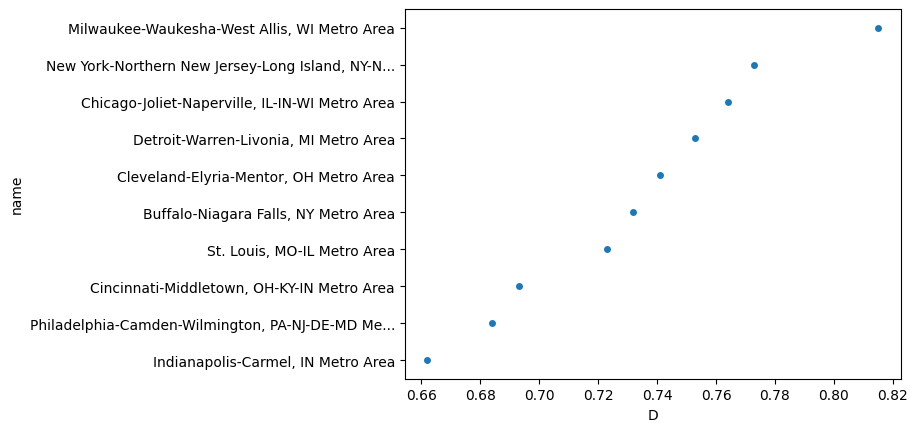

In [23]:
# Plot ten most segregated metros
sns.stripplot(x = "D", y = "name", data = msa.nlargest(10, "D"))
plt.show()

## 1.3.7 Create Function to Calculate D

In [24]:
def dissimilarity(df, col_A, col_B, group_by):

    # Sum Group A and Group B by grouping column
    grouped_sums = df.groupby(group_by)[[col_A, col_B]].sum()
    tmp = pd.merge(df, grouped_sums, left_on = group_by,  right_index = True, suffixes = ("", "_sum"))
    
    # Calculate inner expression
    tmp["D"] = abs(tmp[col_A] / tmp[col_A + "_sum"] - tmp[col_B] / tmp[col_B + "_sum"])
    
    # Calculate Index of Dissimilarity and convert to DataFrame
    return 0.5 * tmp.groupby(group_by)["D"].sum().to_frame()

In [25]:
msa_tracts.drop(['white_sum','black_sum'], axis=1, inplace=True)
msa_tracts.head()

,state,county,tract,white,black,msa,msa_name,metro_micro,county_name,state_name
44,1,7,10001,2368,269,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,Bibb County,Alabama
45,1,7,10002,5554,321,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,Bibb County,Alabama
46,1,7,10003,4384,814,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,Bibb County,Alabama
47,1,7,10004,4885,3620,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,Bibb County,Alabama
48,1,9,50101,6152,238,13820,"Birmingham-Hoover, AL",Metropolitan Statistical Area,Blount County,Alabama


In [26]:
msa_tracts.shape

(36235, 10)

In [27]:
msa_D = dissimilarity(msa_tracts, "white", "black", "msa_name")
print(msa_D.head())

                                          D
msa_name                                   
Atlanta-Sandy Springs-Roswell, GA  0.589134
Austin-Round Rock, TX              0.500542
Baltimore-Columbia-Towson, MD      0.654181
Birmingham-Hoover, AL              0.657886
Boston-Cambridge-Newton, MA-NH     0.640237


## 1.3.8 Characteristics of Segregated Metros

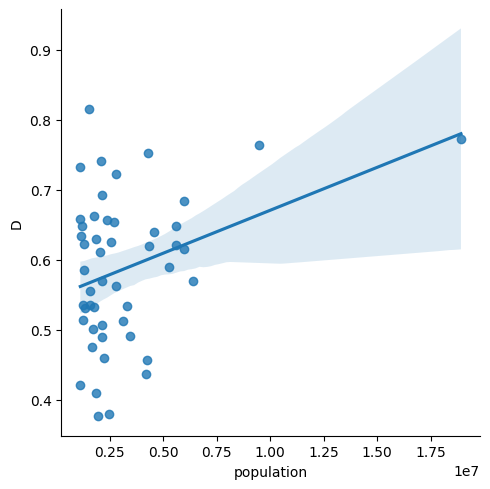

In [28]:
# Are large metros more segregated?
sns.lmplot(x = "population", y = "D", data = msa)
plt.show()

In [29]:
# Calculate percentage African-American
msa["black_pct"] = 100 * msa["black"] / msa["population"]

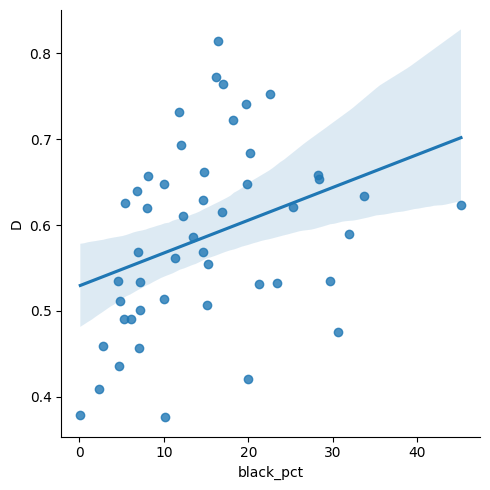

In [30]:
# Are more diverse metros more segregated?
sns.lmplot(x = "black_pct", y = "D", data = msa)
plt.show()

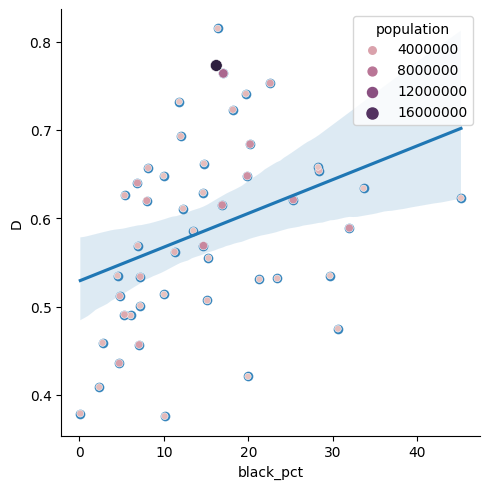

In [31]:
# Are more diverse metros more segregated?
sns.lmplot(x = "black_pct", y = "D", data = msa)

# Display metro size, percent Black, and segregation in one plot
sns.scatterplot(x = "black_pct", y = "D", size = "population", 
                hue = "population", data = msa)
plt.show()

## 0.3.10 Calculating Unemployment

In [32]:
msa_black_emp = pd.read_csv(path.data_raw_dir("census/msa_black_emp.csv"), sep=',')
print(msa_black_emp.info())
msa_black_emp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   male_lf       49 non-null     int64
 1   male_unemp    49 non-null     int64
 2   female_lf     49 non-null     int64
 3   female_unemp  49 non-null     int64
 4   msa           49 non-null     int64
dtypes: int64(5)
memory usage: 2.0 KB
None


,male_lf,male_unemp,female_lf,female_unemp,msa
0,400843,68832,481425,74942,12060
1,30656,6194,35046,4939,25540
2,231346,32716,268923,31256,26420
3,55943,10781,71036,11696,26900
4,62434,11324,74028,11385,27260


In [33]:
# Calculate percentage unemployment for male, female, and all
msa_black_emp["pct_male_unemp"] = 100 * msa_black_emp['male_unemp'] / msa_black_emp['male_lf']
msa_black_emp["pct_female_unemp"] = 100 * msa_black_emp['female_unemp'] / msa_black_emp['female_lf']
msa_black_emp["pct_unemp"] = 100 * (msa_black_emp['female_unemp'] + msa_black_emp['male_unemp']) / (msa_black_emp['male_lf'] + msa_black_emp['female_lf'])

In [34]:
# Merge with Index of Dissimilarity calculated previously
msa_black_emp = pd.merge(msa, msa_black_emp, on='msa')

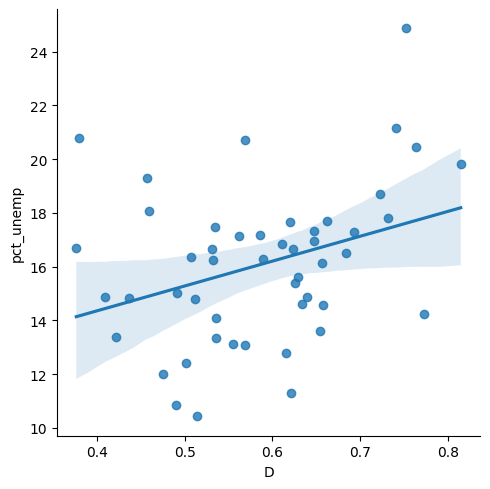

In [35]:
# Plot unemployment vs. segregation
sns.lmplot(x = 'D', y = 'pct_unemp', data = msa_black_emp)
plt.show()

## 0.3.11 Impacts of Black-White Segregation by Sex

In [36]:
# Restrict DataFrame to columns of interest, rename columns
tidy_black_emp = msa_black_emp[["msa", "D", "pct_male_unemp", "pct_female_unemp"]]
tidy_black_emp.columns = ["msa", "D", "male", "female"]

In [37]:
# Use melt to create tidy DataFrame
tidy_msa_emp = tidy_black_emp.melt(id_vars = ['msa','D'], 
                                   value_vars = ['male','female'], 
                                   var_name = "sex",
                                   value_name = "unemployment")
print(tidy_msa_emp.head())

     msa      D   sex  unemployment
0  41980  0.379  male     21.430742
1  12060  0.589  male     17.171810
2  12420  0.501  male     14.398047
3  12580  0.654  male     15.569452
4  13820  0.658  male     15.323874


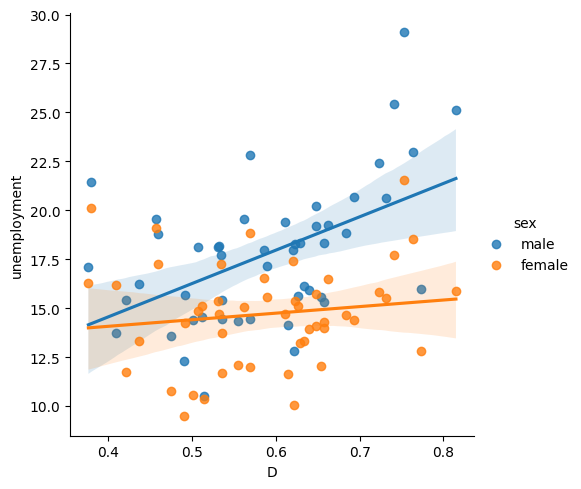

In [38]:
# Visually compare male and female unemployment
sns.lmplot(x='D', y='unemployment', hue = 'sex', data = tidy_msa_emp)
plt.show()

## 0.3.12 White and Black Unemployment

In [39]:
msa_white_emp = pd.read_csv(path.data_raw_dir("census/msa_white_emp.csv"), sep=',')
print(msa_white_emp.info())
msa_white_emp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              955 non-null    object 
 1   male_lf           955 non-null    int64  
 2   male_unemp        955 non-null    int64  
 3   female_lf         955 non-null    int64  
 4   female_unemp      955 non-null    int64  
 5   msa               955 non-null    int64  
 6   pct_male_unemp    955 non-null    float64
 7   pct_female_unemp  955 non-null    float64
 8   pct_unemp         955 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 67.3+ KB
None


,name,male_lf,male_unemp,female_lf,female_unemp,msa,pct_male_unemp,pct_female_unemp,pct_unemp
0,"Abbeville, LA Micro Area",12441,637,9406,613,10020,5.120,6.517,5.722
1,"Aberdeen, SD Micro Area",10525,315,9673,229,10100,2.993,2.367,2.693
2,"Aberdeen, WA Micro Area",14518,2591,12761,1515,10140,17.847,11.872,15.052
3,"Abilene, TX Metro Area",30939,1880,29942,1543,10180,6.076,5.153,5.622
4,"Ada, OK Micro Area",6968,449,6426,363,10220,6.444,5.649,6.062


In [41]:
# Restrict DataFrame to columns of interest, rename columns
tidy_black_emp = msa_black_emp[["msa", "D", "pct_male_unemp"]]
tidy_black_emp.columns = ["msa", "D", "black"]
tidy_white_emp = msa_white_emp[["msa", "pct_male_unemp"]]
tidy_white_emp.columns = ["msa", "white"]
tidy_emp = pd.merge(tidy_black_emp, tidy_white_emp, on = "msa")

In [42]:
tidy_emp.head()

,msa,D,black,white
0,41980,0.379,21.430742,15.862
1,12060,0.589,17.171810,8.220
2,12420,0.501,14.398047,7.192
3,12580,0.654,15.569452,6.479
4,13820,0.658,15.323874,8.014


In [43]:
# Use melt to create tidy DataFrame
tidy_msa_emp = tidy_emp.melt(id_vars = ["msa", "D"], 
                             value_vars = ['black','white'], 
                             var_name = 'race', 
                             value_name = 'unemployment')
tidy_msa_emp.head()

,msa,D,race,unemployment
0,41980,0.379,black,21.430742
1,12060,0.589,black,17.171810
2,12420,0.501,black,14.398047
3,12580,0.654,black,15.569452
4,13820,0.658,black,15.323874


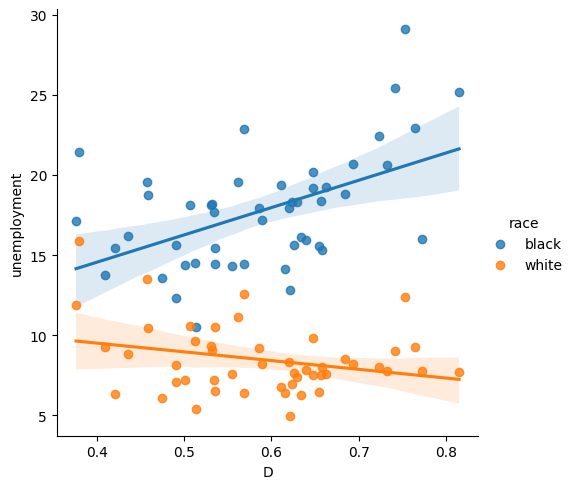

In [45]:
# Visually compare male and female unemployment
sns.lmplot(x='D', y='unemployment', hue='race', data = tidy_msa_emp)
plt.show()

## 0.3.13 Tract Demographics in a Segregated City

In [46]:
tracts_cook = pd.read_csv(path.data_raw_dir("census/tracts_cook.csv"), sep=',')
print(tracts_cook.info())
tracts_cook.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   state          1314 non-null   int64
 1   county         1314 non-null   int64
 2   tract          1314 non-null   int64
 3   black_1990     1314 non-null   int64
 4   black_2010     1314 non-null   int64
 5   totalpop_1990  1314 non-null   int64
 6   totalpop_2010  1314 non-null   int64
dtypes: int64(7)
memory usage: 72.0 KB
None


,state,county,tract,black_1990,black_2010,totalpop_1990,totalpop_2010
0,17,31,10100,3050,2390,6409,4854
1,17,31,10201,2658,2291,6524,6450
2,17,31,10202,520,935,2657,2818
3,17,31,10300,1618,1691,6835,6236
4,17,31,10400,734,707,5670,5042


In [47]:
# Calculate percent Black in 2010
tracts_cook["pct_black_2010"] = 100 * tracts_cook['black_2010'] / tracts_cook['totalpop_2010']

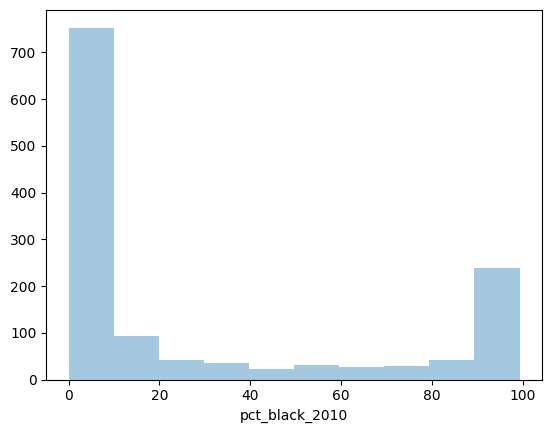

In [48]:
# Examine histogram of percent Black
sns.distplot(tracts_cook['pct_black_2010'], kde=False)
plt.show()

## 0.3.14 Segregation Begets More Segregation

In [49]:
# Calculate percent Black in 1990 and percentage point change from 1990 to 2000
tracts_cook["pct_black_1990"] = 100 * tracts_cook["black_1990"] / tracts_cook["totalpop_1990"]
tracts_cook["pct_black_change"] = tracts_cook["pct_black_2010"] - tracts_cook["pct_black_1990"]

In [51]:
# Retain tracts between 30% and 70% Black in 1990
tracts_mixed = tracts_cook[(tracts_cook["pct_black_1990"] >= 30) & (tracts_cook["pct_black_1990"] <= 70)]

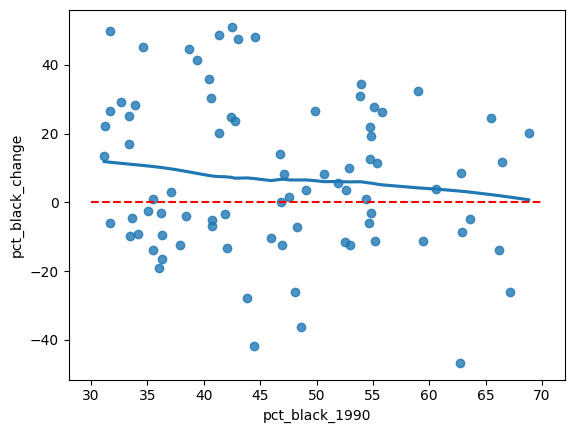

In [56]:
# Plot change vs. percent Black in 1990, with "no change" reference line
sns.regplot(x = "pct_black_1990", y = "pct_black_change", lowess = True, data = tracts_mixed)
plt.plot([30, 70], [0, 0], linestyle = "--", color = "red")
plt.show()

## 0.3.15 Population Decline in Segregated Neighborhoods

In [59]:
# Calculate percent population change 1990-2010
tracts_cook["pct_pop_change"] = 100 * (tracts_cook["totalpop_2010"] - tracts_cook["totalpop_1990"])/tracts_cook["totalpop_1990"]

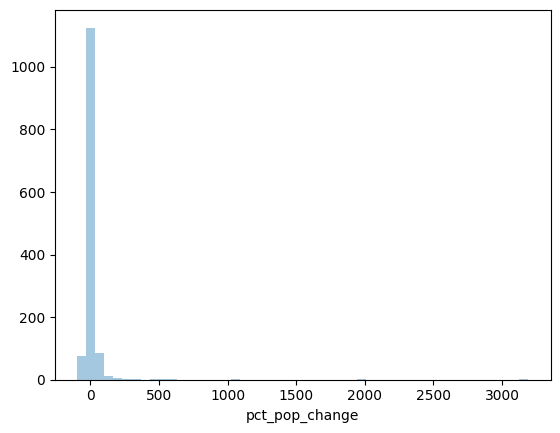

In [60]:
# Examine histogram of percent population change
sns.distplot(tracts_cook['pct_pop_change'], kde=False)
plt.show()

In [61]:
# Filter out very high growth census tracts
tracts_change = tracts_cook[tracts_cook["pct_pop_change"] <= 100]

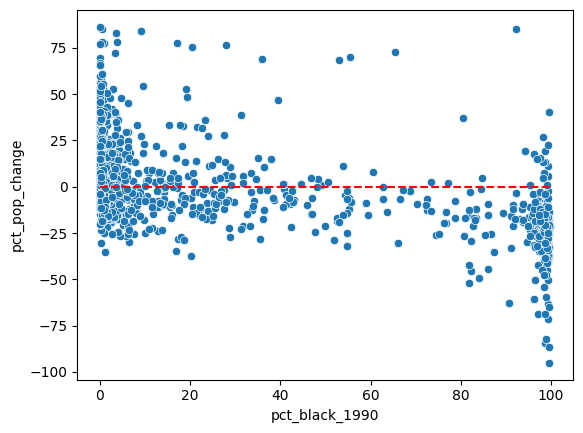

In [62]:
# Plot population change vs. percent Black in 1990
sns.scatterplot(x = "pct_black_1990", y = "pct_pop_change", data = tracts_change)
plt.plot([0, 100], [0, 0], linestyle = "--", color = "red")
plt.show()

Notice again that there are relatively few census tracts in Cook County with a mix of African-Americans and other races. Moreover, notice that a large majority of heavily African-American tracts (the right side of the plot) lost population–in some cases nearly all of their population.

In [4]:
malla = gpd.read_file(path.data_external_dir("census/malla.geojson"))
malla.head()

,OBJECTID,MVICCALZAD,MVICCAT,MVITIPO,MVINOMBRE,MVINALTERN,MVINPRINCI,MVINGENERA,MVINANTIGU,MVIETIQUET,MVISVIA,MVICIV,MVINVIA,MVIEVIA,MVIFRIGHT,MVITRIGHT,MVIFLEFT,MVITLEFT,MVITM,MVICM,MVINUMC,MVIACAL,MVIEFUN,MVITCONE,NAME,MUNICIPIO,PREFIJO,MVIVEL,MVIBICI,MVIRCAR,MVIESTV,MVITC,MVIRAPS,MVITSUP,MVIMONIT,MVICODIGO,CREADOR,CREADOR_DATE,EDITOR,EDITOR_DATE,MVI_VELREG,Shape__Length,geometry
0,1,168175.0,18005353,KR,,,008A0000E0,05700000S0,KR 14A E,KR 8A E,SD,18006831.0,0,M,2.0,98.0,99.0,97.0,0,0,1.0,3.5,SD,5,8A -57,BOGOTA,SE,None,None,None,0,0,0,2,0,96282,None,NaT,SIGADMIN,2014-01-22 19:06:43+00:00,30.0,0.000320,"LINESTRING (-74.09821 4.53521, -74.09846 4.53500)"
1,2,34104.0,8001090,CL,,,04200000S0,0980000000,CL 42 S,CL 42 S,B,8000857.0,0,M,2.0,98.0,99.0,97.0,0,0,1.0,4.0,SD,5,42 -98,BOGOTA,S,None,None,None,0,0,0,6,0,62558,None,NaT,SIGADMIN,2014-01-22 17:48:21+00:00,30.0,0.000233,"LINESTRING (-74.17653 4.64671, -74.17666 4.64690)"
2,3,34338.0,2000900,TV,,,00600000E0,0970000000,TV 6 E,TV 6 E,B,1005995.0,0,M,2.0,98.0,99.0,97.0,0,0,2.0,5.2,SD,5,6 E-97,BOGOTA,,None,None,None,0,0,0,1,0,33964,None,NaT,SIGADMIN,2014-01-22 18:52:11+00:00,NaN,0.000862,"LINESTRING (-74.02180 4.66853, -74.02161 4.66937)"
3,4,3192.0,1000290,CL,,,183B000000,0080000000,CL 183B,CL 183B,B,1000874.0,0,R,2.0,98.0,99.0,97.0,0,0,2.0,6.5,SD,5,183B-8,BOGOTA,,None,None,None,0,0,0,6,0,29147,None,NaT,SIGADMIN,2014-01-22 19:20:55+00:00,30.0,0.001055,"LINESTRING (-74.02901 4.76098, -74.02910 4.760..."
4,5,33331.0,8001681,KR,,,0810000000,008A000000,KR 84D,KR 81,B,8001417.0,0,M,2.0,98.0,99.0,97.0,0,0,NaN,0.0,SD,5,81-8A,BOGOTA,,None,None,None,0,0,0,12,0,133742,None,NaT,SIGADMIN,2014-01-22 18:26:11+00:00,30.0,0.000533,"LINESTRING (-74.14690 4.64391, -74.14651 4.64427)"


In [ ]:
print('ok_')

ok_
